# Quality Control

Let's first import the necessary libraries and load the data.

In [21]:
import numpy as np
import scanpy as sc
import seaborn as sns
import pandas as pd
import anndata2ri
import logging
from scipy.stats import median_abs_deviation

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

import sys

sys.path.append("../src")

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [22]:
# Determine the timepoint, strain, and replicate (if strain is acaA_pkaC)
tp = "00hr"
strain = "AX4"
replicate = "r3"

In [24]:
if strain == "acaA_pkaC":
    adata = sc.read_10x_h5(
        f"../data/raw/{strain}/{strain}_{tp}_{replicate}_filtered_feature_bc_matrix.h5"
    )
    adata.obs["marker"] = replicate
else:
    adata = sc.read_10x_h5(
        f"../data/raw/{strain}/{strain}_{tp}_filtered_feature_bc_matrix.h5"
    )
adata

AnnData object with n_obs × n_vars = 13996 × 12889
    var: 'gene_ids', 'feature_types', 'genome'

After reading the data, scanpy displays a warning that not all variable names are unique. This indicates that some variables (=genes) appear more than once which can lead to errors or unintended behavior for downstream analysis tasks. We execute the proposed function `var_names_make_unique()` which makes the variable name unique by appending a number string to each duplicate index element: ‘1’, ‘2’, etc. 

In [94]:
adata.var_names_make_unique()
adata.obs["time"] = tp
adata.obs["strain"] = strain
adata

AnnData object with n_obs × n_vars = 17552 × 12889
    obs: 'time', 'strain'
    var: 'gene_ids', 'feature_types', 'genome'


Single-cell RNA-seq datasets can contain low-quality cells, cell-free RNA and doublets. Quality control aims to remove and correct for those to obtain a high-quality dataset where each observation is an intact single cell. 

## Filtering low quality cells

The first step in quality control is to remove low-quality cells from the dataset. When a cell has a low number of detected genes, a low count depth and a high fraction of mitochondrial counts it might have a broken membrane which can indicate a dying cell. As these cells are usually not the main target of our analysis and might distort our downstream analysis, we are removing them during quality control. For identifying them, we define cell quality control (QC) threshold. Cell QC is typically performed on the following three QC covariates:

1. The number of counts per barcode (count depth)
2. The number of genes per barcode
3. The fraction of counts from mitochondrial genes per barcode

In cell QC these covariates are filtered via thresholding as they might correspond to dying cells. As indicated, they might reflect cells with broken membranes whose cytoplasmic mRNA has leaked out and therefore only the mRNA in the mitochondria is still present. These cells might then show a low count depth, few detected genes and a high fraction of mitochondrial reads. It is, however, crucial to consider the three QC covariates jointly as otherwise it might lead to misinterpretation of cellular signals.

QC on only a few or small datasets is often performed in a manual fashion by looking at the distribution of different QC covariates and identifying outlier which will be filtered afterwards. However, as datasets grow in size this task is becoming more and more time-consuming and it might be worth considering automatic thresholding via MAD (median absolute deviations). The MAD is given by $MAD = median(|X_i - median(X)|)$ with $X_i$ being the respective QC metric of an observation and describes a robust statistic of the variability of the metric. Similar to {cite}`qc:germain_pipecomp_2020`, we mark cells as outliers if they differ by 5 MADs which is a relatively permissive filtering strategy. We want to highlight that it might be reasonable to re-assess the filtering after annotation of cells.


We can now calculate the respective QC metrics with scanpy. 

In [5]:
from genes import mt_genes

In [6]:
adata.var["mt"] = pd.Series(adata.var["gene_ids"]).isin(mt_genes).values
print(adata.var["mt"].value_counts())

mt
False    12847
True        42
Name: count, dtype: int64


In [7]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 13996 × 12889
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

As we can see, the function added a couple of additional columns to `.var` and `.obs`. We want to highlight a few of them here, more information on the different metrics can be found in the scanpy documentation:

* `n_genes_by_counts` in `.obs` is the number of genes with positive counts in a cell,
* `total_counts` is the total number of counts for a cell, this might also be known as library size, and
* `pct_counts_mt` is the proportion of total counts for a cell which are mitochondrial.

We now plot the three QC covariates `n_genes_by_counts`, `total_counts` and `pct_counts_mt` per sample to assess how well the respective cells were captured. 

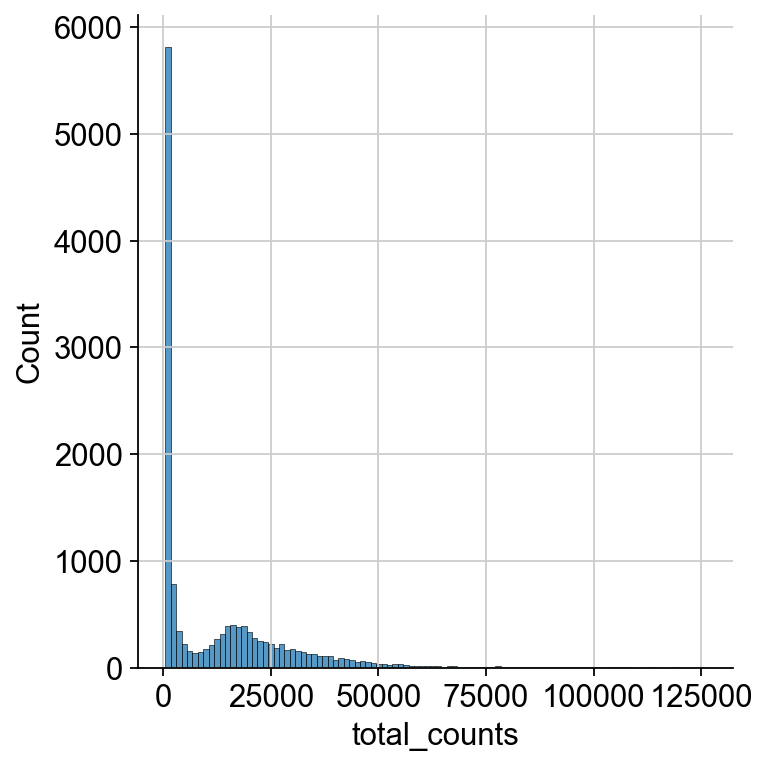

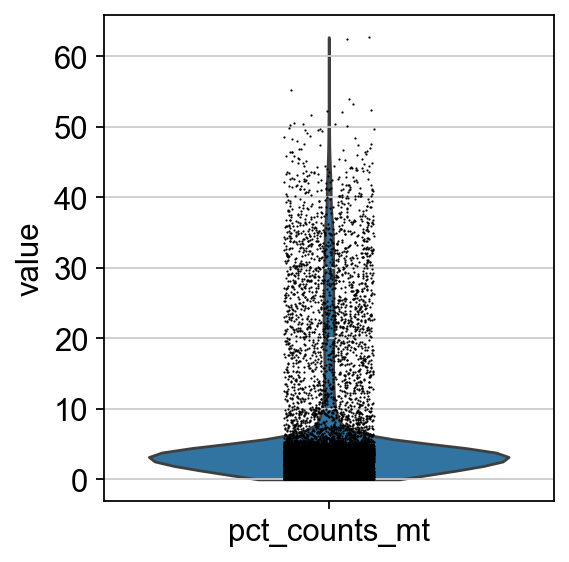

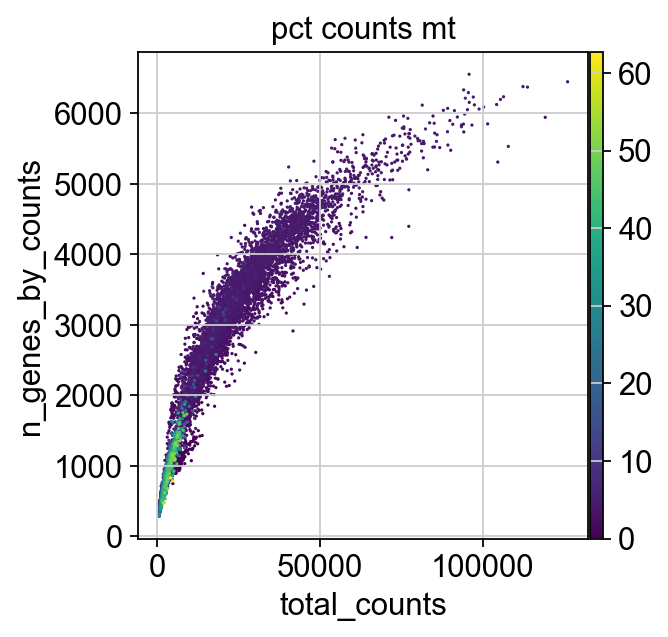

In [8]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

First, we define a function that takes a `metric`, i.e. a column in `.obs` and the number of MADs (`nmad`) that is still permissive within the filtering strategy. 

In [9]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

We now apply this function to the `log1p_total_counts`, `log1p_n_genes_by_counts` and `pct_counts_in_top_20_genes` QC covariates each with a threshold of 5 MADs.

In [11]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    13353
True       643
Name: count, dtype: int64

`pct_counts_mt` is filtered with 3 MADs. Additionally, cells with a percentage of mitochondrial counts exceeding 20 % are filtered out.

In [12]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 20
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    11769
True      2227
Name: count, dtype: int64

We now add column `outlier_all` to our AnnData object based on these two additional columns.

In [14]:
adata.obs["outlier_all"] = adata.obs["outlier"] | adata.obs["mt_outlier"]
adata.obs.outlier_all.value_counts()

outlier_all
False    11763
True      2233
Name: count, dtype: int64

In [15]:
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/var/folders/b0/d34rvffj6l18k2sl5mb16w440000gn/T/ipykernel_24025/3679384608.py:3: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


## Doublet Detection

Doublets are defined as two cells that are sequenced under the same cellular barcode, for example, if they were captured in the same droplet. That's why we used the term "barcode" instead of "cell" until now. A doublet is called homotypic if it is formed by the same cell type (but from different individuals) and heterotypic otherwise. Homotypic doublets are not necessarily identifiable from count matrices and are often considered innocuous as they can be identified with cell hashing or SNPs. Hence, their identification is not the main goal of the doublet detection methods. 

Doublets formed from different cell types or states are called heterotypic. Their identification is crucial as they are most likely misclassified and can lead to distorted downstream analysis steps. Hence, doublet detection and removal are typically initial preprocessing steps. Doublets can be either identified through their high number of reads and detected features, or with methods that create artificial doublets and compare these with the cells present in the dataset. Doublet detection methods are computationally efficient and there exist several software packages for this task. 

{cite}`xi_benchmarking_2021` benchmarked nine different doublet detection methods and assessed their performance with respect to computational efficiency and doublet detection accuracy. They additionally assessed scDblFinder in an addendum to their benchmark which achieved the highest doublet detection accuracy and a good computational efficiency and stability {cite}`Xi_2021_addendum`.

In [16]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Loading required package: SeuratObject
Loading required package: sp

Attaching package: ‘SeuratObject’

The following objects are masked from ‘package:base’:

    intersect, t

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts,

In [17]:
data_mat = adata.X.T

We can now launch the doublet detection by using data_mat as input to scDblFinder within a SingleCellExperiment. scBblFinder adds several columns to the colData of sce. Three of them might be interesting for the analysis:

* `sce$scDblFinder.score`: the final doublet score (the higher the more likely that the cell is a doublet)

* `sce$scDblFinder.ratio` : the ratio of artificial doublets in the cell's neighborhood

* `sce$scDblFinder.class` : the classification (doublet or singlet)

We will only output the class argument and store it in the AnnData object in `.obs` . The other arguments can be added to the AnnData object similarly.

In [18]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~11197 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 2741 cells excluded from training.
iter=1, 2865 cells excluded from training.
iter=2, 2883 cells excluded from training.
Threshold found:0.42
2097 (15%) doublets called


scDblFinder outputs a class with the classification `Singlet` (1) and `Doublet` (2). We add this to our AnnData object in `.obs`.

In [19]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs = adata.obs.rename(columns={"scDblFinder_score": "doublet_score", "scDblFinder_class": "doublet"})
adata.obs.doublet.value_counts()

doublet
singlet    11899
doublet     2097
Name: count, dtype: int64

# Save preprocessed data

In [ ]:
genes_to_remove = ['mCerulean', 'mCherry', 'mNeonG', 'NeoR', 'act15GFP','coaABSR']
if strain == "acaA_pkaC":
    adata = adata[:, ~adata.var_names.isin(genes_to_remove)]
    adata.write(f"../data/temp/{strain}/{strain}_{tp}_{replicate}.h5ad")
else:
    for gene in genes_to_remove:
       if gene in adata.var_names:
              adata.obs[gene] = adata[:, gene].X.toarray().flatten() # add gene expression to obs to later determine marker tag
    adata = adata[:, ~adata.var_names.isin(genes_to_remove)]
    adata.write(f"../data/processed/{strain}/{strain}_{tp}.h5ad")

Next use the [UCE embedder](https://github.com/snap-stanford/UCE?tab=readme-ov-file) to embed the cells, change the `UCE_DATA_DIRECTORY` in `constants.py` to the uce_data file directory and then use the **Concatenate anndatas for mutants and UCE data** section in `utils.ipynb` to concatenate the anndatas and add the UCE embeddings.